In [1]:
from data_utils import *
from model_utils import *
from train_utils import *
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
print(f"Data Path being used: {DATA_PATH}")
dataset = load_dataset_for_lstm()
classes = dataset.classes

train_dataset, val_dataset = split_dataset(dataset, val_ratio=0.2, random_seed=42)
train_loader, val_loader = get_loaders(train_dataset, val_dataset, batch_size=32)

print(f"Aantal classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")


Data Path being used: c:\Studies\Smartglass Project\SmartGlasses\notebooks\package\smart_gestures\gestures\lstm_model\dataset
Found 5 gestures: ['goed', 'hallo', 'ja', 'nee', 'tot_ziens']
Aantal classes: 5
Classes: ['goed', 'hallo', 'ja', 'nee', 'tot_ziens']
Training sequences: 117
Validation sequences: 29


In [3]:
in_dim = 258
num_classes = len(classes)
HIDDEN_SIZE = 128
NUM_LAYERS = 2
SEQUENCE_LENGTH_REF = SEQUENCE_LENGTH # Add for reference

model = create_model(num_classes, in_dim, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

try:
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'lstm_model.pth'), map_location=DEVICE))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    print("No pre-trained weights found. Starting from scratch.")

Model weights loaded successfully.


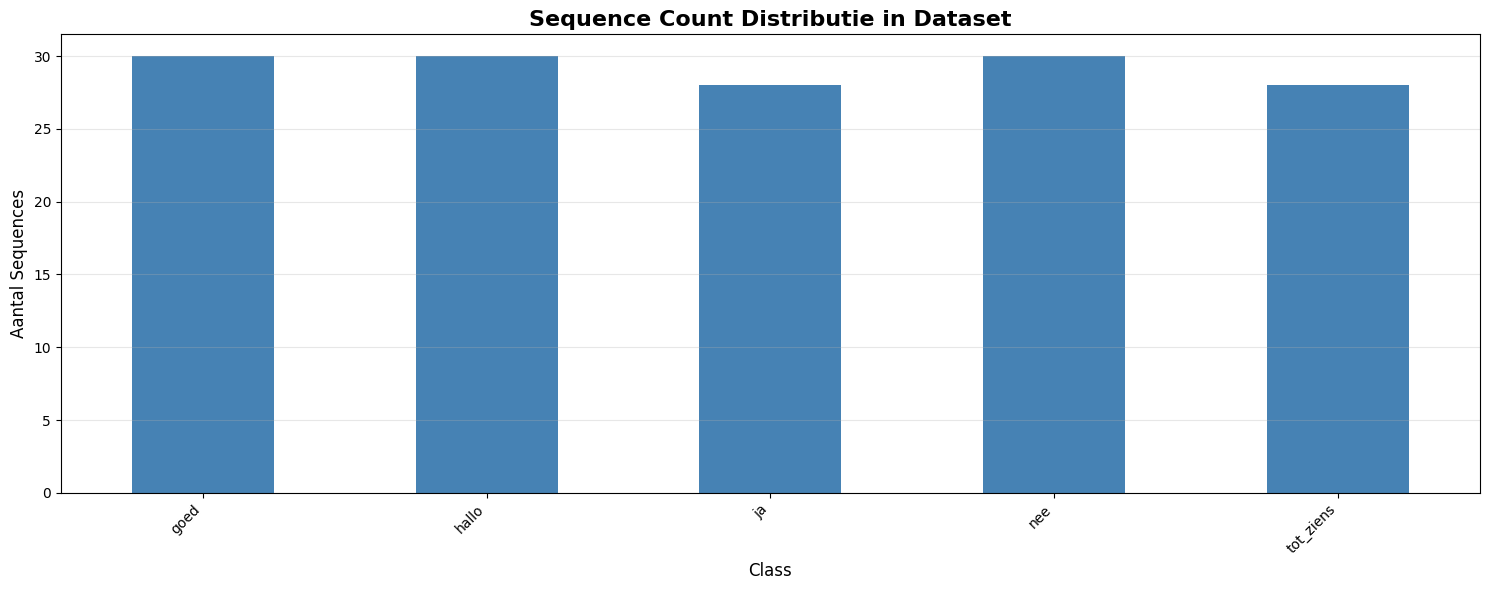


Totaal aantal sequences: 146
Gemiddeld aantal sequences per class: 29.2
Min sequences: 28, Max sequences: 30


In [4]:
label_counts = {}
for idx in dataset.y:
    gesture_name = dataset.classes[idx]
    label_counts[gesture_name] = label_counts.get(gesture_name, 0) + 1

class_counts = pd.Series(label_counts).sort_index()

plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Sequence Count Distributie in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Aantal Sequences', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotaal aantal sequences: {len(dataset)}")
print(f"Gemiddeld aantal sequences per class: {class_counts.mean():.1f}")
print(f"Min sequences: {class_counts.min()}, Max sequences: {class_counts.max()}")

In [5]:
# 1. Collect all predictions, labels, and confidence scores
all_preds = []
all_labels = []
all_confidences = []
correct_confidences = []
incorrect_confidences = []

model.eval()
with torch.no_grad():
    for inputs, labels, lengths in val_loader:
        inputs = inputs.to(DEVICE)
        
        # Forward pass (LSTM requires inputs AND lengths)
        outputs = model(inputs, lengths) 
        
        # Get probabilities using Softmax
        probs = torch.softmax(outputs, dim=1)
        
        # Get the max probability (confidence) and the predicted class
        confidences, predicted = torch.max(probs.data, 1)
        
        # Store results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        
        # Separate confidences into correct and incorrect for analysis later
        for conf, pred, label in zip(confidences.cpu().numpy(), 
                                     predicted.cpu().numpy(), 
                                     labels.numpy()):
            all_confidences.append(conf)
            if pred == label:
                correct_confidences.append(conf)
            else:
                incorrect_confidences.append(conf)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate overall accuracy
accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 79.31%


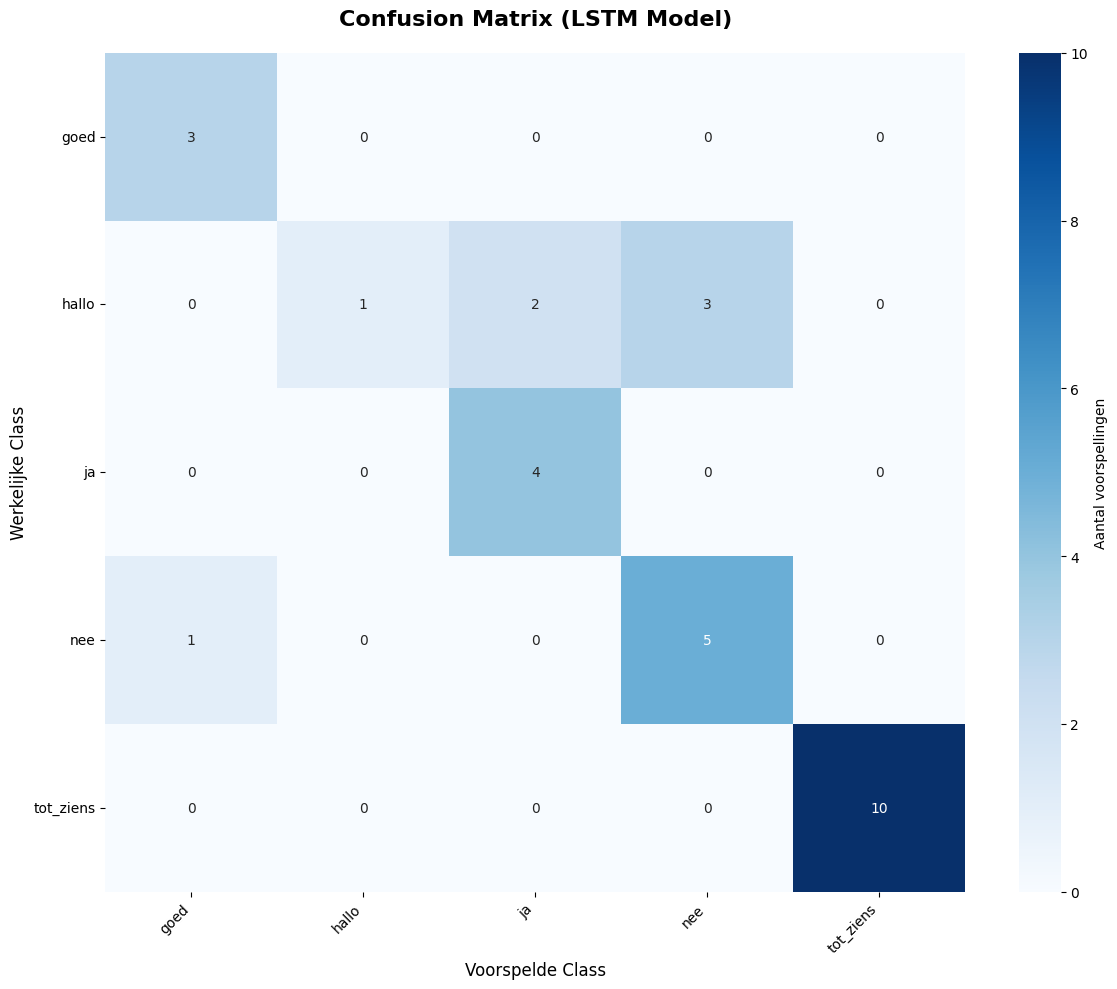

In [6]:
# 2. Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Aantal voorspellingen'})
plt.title('Confusion Matrix (LSTM Model)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Werkelijke Class', fontsize=12)
plt.xlabel('Voorspelde Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
# 3. Print Classification Report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_labels, all_preds, target_names=classes, digits=3))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

        goed      0.750     1.000     0.857         3
       hallo      1.000     0.167     0.286         6
          ja      0.667     1.000     0.800         4
         nee      0.625     0.833     0.714         6
   tot_ziens      1.000     1.000     1.000        10

    accuracy                          0.793        29
   macro avg      0.808     0.800     0.731        29
weighted avg      0.851     0.793     0.751        29



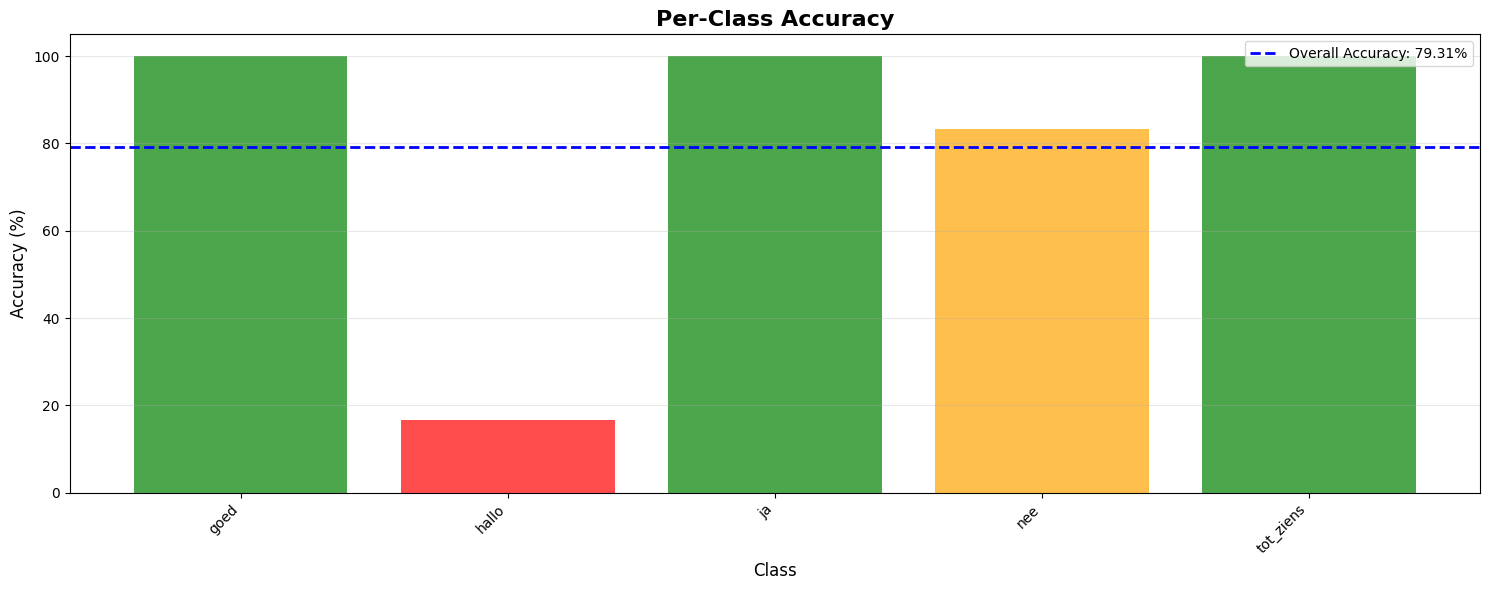


Classes met laagste accuracy:
  hallo: 16.67%
  nee: 83.33%
  goed: 100.00%
  ja: 100.00%
  tot_ziens: 100.00%


In [8]:
# 4. Calculate and Plot Per-Class Accuracy
per_class_accuracy = []
for i in range(len(classes)):
    mask = all_labels == i
    if mask.sum() > 0:
        acc = 100 * (all_preds[mask] == all_labels[mask]).sum() / mask.sum()
        per_class_accuracy.append(acc)
    else:
        per_class_accuracy.append(0)

plt.figure(figsize=(15, 6))
# Color code: Green > 90%, Orange > 70%, Red < 70%
colors = ['green' if acc >= 90 else 'orange' if acc >= 70 else 'red' for acc in per_class_accuracy]

plt.bar(classes, per_class_accuracy, color=colors, alpha=0.7)
plt.axhline(y=accuracy, color='blue', linestyle='--', label=f'Overall Accuracy: {accuracy:.2f}%', linewidth=2)
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print classes with lowest accuracy
print("\nClasses met laagste accuracy:")
sorted_indices = np.argsort(per_class_accuracy)[:5]
for idx in sorted_indices:
    print(f"  {classes[idx]}: {per_class_accuracy[idx]:.2f}%")

C:\Users\olivi\AppData\Local\Temp\ipykernel_11864\889880719.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels_to_plot)


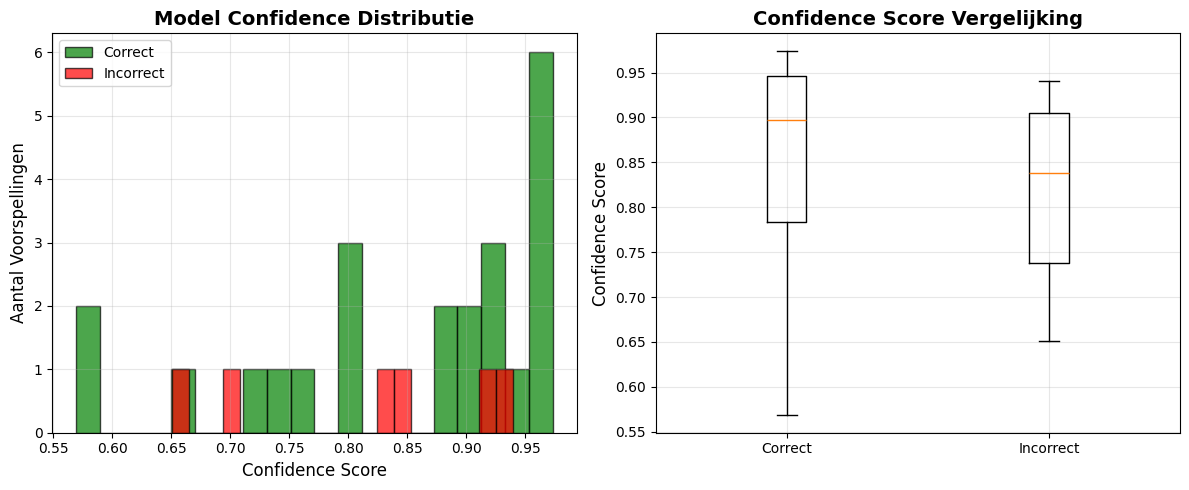


Gemiddelde confidence (correct): 0.8500
Gemiddelde confidence (incorrect): 0.8166


In [9]:
# 5. Plot Confidence Distribution
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
if len(correct_confidences) > 0:
    plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct', color='green', edgecolor='black')
if len(incorrect_confidences) > 0:
    plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Aantal Voorspellingen', fontsize=12)
plt.title('Model Confidence Distributie', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
data_to_plot = []
labels_to_plot = []

if len(correct_confidences) > 0:
    data_to_plot.append(correct_confidences)
    labels_to_plot.append('Correct')
if len(incorrect_confidences) > 0:
    data_to_plot.append(incorrect_confidences)
    labels_to_plot.append('Incorrect')

if data_to_plot:
    plt.boxplot(data_to_plot, labels=labels_to_plot)
    plt.ylabel('Confidence Score', fontsize=12)
    plt.title('Confidence Score Vergelijking', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

if len(correct_confidences) > 0:
    print(f"\nGemiddelde confidence (correct): {np.mean(correct_confidences):.4f}")
if len(incorrect_confidences) > 0:
    print(f"Gemiddelde confidence (incorrect): {np.mean(incorrect_confidences):.4f}")

In [10]:
# 6. Model Architecture and Parameters
print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotaal aantal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Input dimensie: {in_dim}")
print(f"Hidden Size: {HIDDEN_SIZE}")
print(f"Sequence Length (Ref): {SEQUENCE_LENGTH_REF}")
print(f"Output classes: {num_classes}")
print(f"Device: {DEVICE}")


MODEL ARCHITECTURE
GestureLSTM(
  (lstm): LSTM(258, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Totaal aantal parameters: 331,397
Trainable parameters: 331,397
Input dimensie: 258
Hidden Size: 128
Sequence Length (Ref): 40
Output classes: 5
Device: cpu
